In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

In [2]:
file_name = "/home/hep/lprate/projects/BlackBoxOptimization/tests_notebooks/local_info.pkl"
with open(file_name, "rb") as f:
    local_info = pickle.load(f)

In [3]:
phi = np.array([
        [0,115.50,50.00, 50.00, 119.00, 119.00, 2.00, 2.00, 1.00, 1.00, 50.00, 50.00, 0.00, 1.9],
        [10,225.38, 52.25, 78.36, 6.54, 9.37, 2.04, 40.36, 1.01, 1.05, 52.88, 82.20, 0.00,  1.9],
        [10,274.43,52.47, 11.70, 41.59, 79.05, 2.19, 2.01, 1.03, 1.00, 54.15, 11.70, 0.00, 1.9],
        [10,284.85, 33.05, 24.10, 55.13, 30.61, 90.36, 2.00, 1.00, 1.00, 33.05, 24.10, 0.11, 1.9],
        [15,114.58, 5.62, 60.38, 31.37, 5.00, 2.00, 2.86, 1.00, 0.74, 5.59, 44.82, 0.00, -1.9],
        [10,165.53, 90.85, 7.44, 137.45, 66.69, 10.09, 2.00, 0.88, 1.00, 80.16, 7.41, 0.00,  -1.9],
        [10,244.28,9.81, 47.60, 19.59, 164.19, 2.00, 2.05, 1.00, 0.89, 9.81, 42.16, 0.10, -1.9]
    ])

bounds = np.array([[  0.0000, 100.0000,   5.0000,   5.0000,   5.0000,   5.0000,   2.0000,
          2.0000,   0.9900,   0.9900,   5.0000,   5.0000,   0.0000,   0.1000,
         10.0000, 100.0000,   5.0000,   5.0000,   5.0000,   5.0000,   2.0000,
          2.0000,   0.9900,   0.9900,   5.0000,   5.0000,   0.0000,   0.1000,
         10.0000, 100.0000,   5.0000,   5.0000,   5.0000,   5.0000,   2.0000,
          2.0000,   0.9900,   0.9900,   5.0000,   5.0000,   0.0000,   0.1000,
         10.0000, 100.0000,   5.0000,   5.0000,   5.0000,   5.0000,   2.0000,
          2.0000,   0.9900,   0.9900,   5.0000,   5.0000,   0.0000,   0.1000,
         10.0000, 100.0000,   5.0000,   5.0000,   5.0000,   5.0000,   2.0000,
          2.0000,   0.3333,   0.3333,   5.0000,   5.0000,   0.0000,  -1.9100,
         10.0000, 100.0000,   5.0000,   5.0000,   5.0000,   5.0000,   2.0000,
          2.0000,   0.3333,   0.3333,   5.0000,   5.0000,   0.0000,  -1.9100,
         10.0000, 100.0000,   5.0000,   5.0000,   5.0000,   5.0000,   2.0000,
          2.0000,   0.3333,   0.3333,   5.0000,   5.0000,   0.0000,  -1.9100],
          [ 50.0000, 350.0000, 250.0000, 250.0000, 250.0000, 250.0000, 150.0000,
        150.0000,   3.0000,   3.0000, 450.0000, 450.0000, 150.0000,   1.9100,
         50.0000, 350.0000, 250.0000, 250.0000, 250.0000, 250.0000, 150.0000,
        150.0000,   3.0000,   3.0000, 450.0000, 450.0000, 150.0000,   1.9100,
         50.0000, 350.0000, 250.0000, 250.0000, 250.0000, 250.0000, 150.0000,
        150.0000,   3.0000,   3.0000, 450.0000, 450.0000, 150.0000,   1.9100,
         50.0000, 350.0000, 250.0000, 250.0000, 250.0000, 250.0000, 150.0000,
        150.0000,   3.0000,   3.0000, 450.0000, 450.0000, 150.0000,   1.9100,
         50.0000, 350.0000, 250.0000, 250.0000, 250.0000, 250.0000, 150.0000,
        150.0000,   3.0000,   3.0000, 450.0000, 450.0000, 150.0000,   1.9100,
         50.0000, 350.0000, 250.0000, 250.0000, 250.0000, 250.0000, 150.0000,
        150.0000,   3.0000,   3.0000, 450.0000, 450.0000, 150.0000,   1.9100,
         50.0000, 350.0000, 250.0000, 250.0000, 250.0000, 250.0000, 150.0000,
        150.0000,   3.0000,   3.0000, 450.0000, 450.0000, 150.0000,   1.9100]])

In [4]:
def calc_delta_loss_torch(delta_phi: np.array, 
                          grad: np.array, 
                          hess: np.array) -> float:
    """
    Estimates the change in loss for a given parameter perturbation using PyTorch.

    This function uses a second-order Taylor expansion to estimate the change
    in the loss function (delta_loss) based on the local gradient and Hessian.

    Args:
        delta_phi: The expected parameter perturbation (a 1D torch.Tensor).
        grad: The gradient of the loss function at the current point (a 1D torch.Tensor).
        hess: The Hessian matrix of the loss function at the current point (a 2D torch.Tensor).

    Returns:
        The estimated change in loss (a scalar float).
    """
    # Linear term: (∇L)ᵀ * δφ
    def normalize_delta(d, lower_bound, upper_bound):
        return d / (upper_bound - lower_bound)

    delta_phi = normalize_delta(delta_phi, bounds[0], bounds[1])
    linear_term = np.dot(grad, delta_phi)

    # Quadratic term: 0.5 * δφᵀ * H * δφ
    quadratic_term = 0.5 * np.dot(delta_phi, np.dot(hess, delta_phi))

    return linear_term + quadratic_term

def argsort_2d_labels(a: np.ndarray, b: np.ndarray):
    dim0_labels = {0: 'HA', 1:'M1', 2:'M2', 3:'M3', 4:'M4', 5:'M5', 6:'M6'}
    dim1_labels = {0: 'Z_gap[cm]', 1: 'Z_len[cm]',
                   2: 'dXIn[cm]', 3: 'dXOut[cm]',
                   4: 'dYIn[cm]', 5: 'dYOut[cm]',
                   6: 'gapIn[cm]', 7: 'gapOut[cm]',
                   8: 'ratio_yokesIn', 9: 'ratio_yokesOut',
                   10: 'dY_yokeIn[cm]', 11: 'dY_yokeOut[cm]',
                   12: 'XmgapIn[cm]', 13: 'NI[A]'}
    
    flat_idx = np.argsort(np.abs(a), axis=None)[::-1]
    rows, cols = np.unravel_index(flat_idx, a.shape)
    
    return [((dim0_labels[int(r)], dim1_labels[int(c)]), a[r, c].item(), b[r, c].item())
            for r, c in zip(rows, cols)]


In [ ]:
norm_factor = 18e9 / 5e6
hessian = local_info["hess"].numpy() * norm_factor
gradient = local_info["grad"].numpy() * norm_factor
loss = local_info["loss"] * norm_factor
sur_loss = local_info["sur_loss"] * 100 * norm_factor
eigenvalues, eigenvectors = np.linalg.eigh(hessian)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
print(f"Hessian eigenvalues: {eigenvalues}")
for idx, (eigval, eigvec) in enumerate(zip(eigenvalues, eigenvectors.T)):
    print(f"Eigenvalue {idx}: {eigval.item()}")
    print(f"Eigenvector {idx}: {eigvec}")
print(f"Initial Surrogate Loss: {loss}")
print(f"Initial Gradient: {gradient}")

Hessian eigenvalues: [ 4.06875854e+03  1.91378540e+03  1.02712959e+02  5.46794662e+01
  3.97153320e+01  2.44307346e+01  1.81470051e+01  1.44305706e+01
  1.13101797e+01  9.09686756e+00  8.41717434e+00  5.93084908e+00
  5.49768543e+00  3.74918795e+00  2.62477088e+00  2.12130284e+00
  1.62438524e+00  1.16898882e+00  7.48146176e-01  6.18695974e-01
  4.90662485e-01  2.97177106e-01  2.86157399e-01  2.25522548e-01
  1.13838330e-01  1.02083564e-01  9.18827951e-02  6.46354854e-02
  2.98293252e-02  5.06625045e-04  3.55473632e-04  2.91739067e-04
  2.71147030e-04  2.62747984e-04  2.00167706e-04  1.92563719e-04
  1.60978176e-04  1.42786055e-04  1.38392454e-04  1.27755833e-04
  1.10493158e-04  9.76814263e-05  7.94171865e-05  6.65504849e-05
  6.14174714e-05  5.90300333e-05  5.61228590e-05  3.96485411e-05
  3.56156997e-05  3.02849985e-05  2.59937060e-05  2.43832492e-05
  2.00425366e-05  1.88525664e-05  1.44361475e-05  1.34713919e-05
  1.12922626e-05  7.93377967e-06  6.70964255e-06  3.77746642e-06
  2.

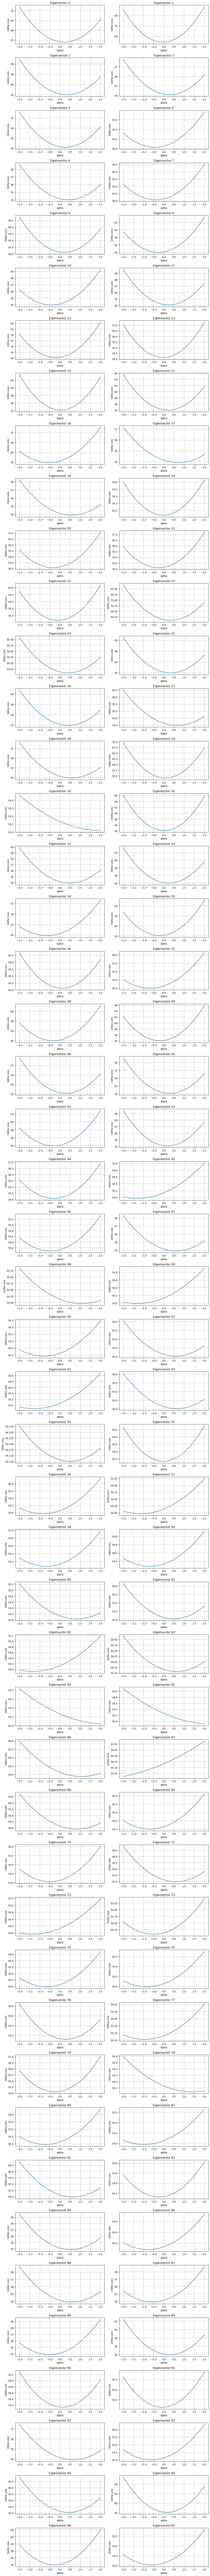

In [6]:
alphas = np.linspace(-2, 2, 100)
# --- New plot: all delta_phi directions in one figure with subplots (2 columns) ---
fig, axes = plt.subplots(nrows=(len(eigenvectors.T)+1)//2, ncols=2, figsize=(12, 3*((len(eigenvectors.T)+1)//2)))
axes = axes.flatten()
for idx, eigvec in enumerate(eigenvectors.T):
    delta_losses = []
    for alpha in alphas:
        delta_phi = alpha * eigvec
        delta_loss = calc_delta_loss_torch(delta_phi, gradient, hessian)
        delta_losses.append(delta_loss + sur_loss)
    axes[idx].plot(alphas, delta_losses)
    axes[idx].set_xlabel('alpha')
    axes[idx].set_ylabel('Delta Loss')
    axes[idx].set_title(f'Eigenvector {idx}')
    axes[idx].grid(True)
# Hide unused subplots if any
for ax in axes[len(eigenvectors.T):]:
    ax.axis('off')
plt.tight_layout()
plt.savefig('delta_loss_vs_alpha_all_eigenvectors.png')

In [7]:
print("Gradient")
# Print gradient without scientific notation
np.set_printoptions(suppress=True)
print(gradient.reshape(7,14))

Gradient
[[ 3.8823793  -5.1117935  -1.8156334   0.884955    0.01291906 -0.81648815
   3.157081   -5.8438697   1.6166819  -2.3659947  -2.51323    -0.15155996
  18.437513    0.21997668]
 [ 1.7815093  -0.7031634  -2.9140677  -0.37178695  1.0814444   3.6646721
   4.05185    -0.45158133  7.321764    0.568285   -0.5399959  -3.2023807
  22.472557   -1.9115614 ]
 [-3.9051783  -0.06958719 -0.5639067   3.1045184   0.6736918   0.728746
  -3.4110012   1.8870491  -4.2120423  -2.5602756  -4.1834903   2.364557
  13.61606    -0.35585716]
 [ 1.419476   -0.84510297 -0.8745123  -1.6313462   0.9389144  -2.4147496
   0.8274571   8.007861   -0.44750577  1.6898817  -2.013738    3.9261515
   6.040459   -0.27202415]
 [-0.24150877 -4.5554886   5.1026726  -0.8500107   0.7522845  -2.3037064
   1.5024      1.3905373   1.1881484   3.6660776   0.17353363 -3.6794543
   2.7847755   4.431794  ]
 [ 4.1303043   0.2738327   1.204521    0.5257068   0.26401237 -0.5511416
   1.5344929   8.099814   -0.8824657  -0.58079916 -1.

In [8]:
for g in argsort_2d_labels(gradient.reshape(7,14), phi):
    if g[0][0] == 'HA': continue
    print('Magnet', g[0][0], 'Param', g[0][1])
    print('Value:', g[2])
    print('Gradient:', g[1], '\n')

Magnet M1 Param XmgapIn[cm]
Value: 0.0
Gradient: 22.472557067871094 

Magnet M2 Param XmgapIn[cm]
Value: 0.0
Gradient: 13.616060256958008 

Magnet M6 Param gapOut[cm]
Value: 2.05
Gradient: 9.662178993225098 

Magnet M5 Param gapOut[cm]
Value: 2.0
Gradient: 8.099814414978027 

Magnet M3 Param gapOut[cm]
Value: 2.0
Gradient: 8.007861137390137 

Magnet M1 Param ratio_yokesIn
Value: 1.01
Gradient: 7.32176399230957 

Magnet M6 Param Z_gap[cm]
Value: 10.0
Gradient: 7.287144184112549 

Magnet M3 Param XmgapIn[cm]
Value: 0.11
Gradient: 6.040459156036377 

Magnet M6 Param gapIn[cm]
Value: 2.0
Gradient: -5.551781177520752 

Magnet M4 Param dXIn[cm]
Value: 5.62
Gradient: 5.102672576904297 

Magnet M6 Param dXIn[cm]
Value: 9.81
Gradient: -4.595158576965332 

Magnet M4 Param Z_len[cm]
Value: 114.58
Gradient: -4.555488586425781 

Magnet M4 Param NI[A]
Value: -1.9
Gradient: 4.431794166564941 

Magnet M2 Param ratio_yokesIn
Value: 1.03
Gradient: -4.212042331695557 

Magnet M2 Param dY_yokeIn[cm]
Value

Analyzing eigenvector 0 with eigenvalue 4068.758544921875
Eigenvector
[[-0.05069259  0.12683551  0.0558724  -0.04453915  0.01190424  0.0168957
  -0.03528567  0.1518287  -0.00320327  0.06199316  0.06050832  0.00927613
  -0.43678048  0.00097932]
 [-0.01771016  0.02226529  0.05588327 -0.00340226 -0.07037849 -0.06711268
  -0.04194752  0.01551147 -0.13182133 -0.05005208  0.0215421   0.04176647
  -0.48642647  0.03914876]
 [ 0.07671697  0.01653971  0.01013444 -0.01703238 -0.0178782  -0.02672723
   0.04758185 -0.05182482  0.13941844 -0.00897041  0.05890689 -0.07802626
  -0.31510624  0.00341066]
 [-0.10699073  0.02683421  0.08076628  0.10620443 -0.03238643  0.02032633
  -0.01124173 -0.13584435 -0.00823864 -0.05905012  0.02988039 -0.0388555
  -0.04600802  0.00639269]
 [-0.00228957  0.07197449 -0.10465261 -0.00318705  0.01280986  0.0228742
  -0.02564641 -0.0267063  -0.01435494 -0.1083151  -0.0193993   0.05211962
  -0.09793048 -0.0734046 ]
 [-0.08026842 -0.01099153 -0.04416906 -0.05227741 -0.00074

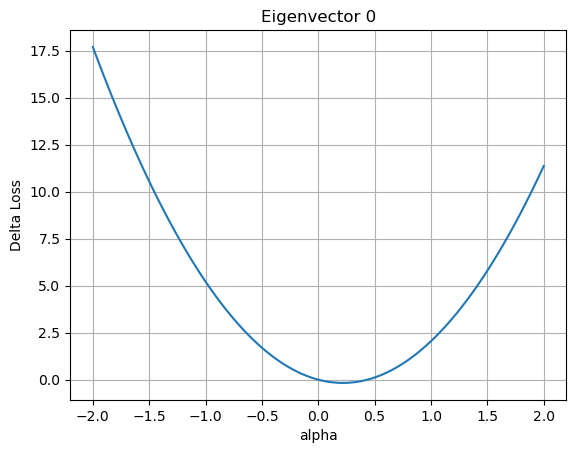

In [9]:
np.set_printoptions(suppress=True)
i = 0
print(f"Analyzing eigenvector {i} with eigenvalue {eigenvalues[i].item()}")
print("Eigenvector")

eigenvec = eigenvectors[:,i]
print(eigenvec.reshape(7,14))
delta_losses = []
for alpha in alphas:
    delta_phi = alpha * eigenvec
    delta_loss = calc_delta_loss_torch(delta_phi, gradient, hessian)
    delta_losses.append(delta_loss)
plt.plot(alphas, delta_losses)
plt.xlabel('alpha')
plt.ylabel('Delta Loss')
plt.title(f'Eigenvector {i}')
plt.grid(True)

Analyzing eigenvector 0 with eigenvalue 4068.758544921875
Eigenvector
[[-0.05069259  0.12683551  0.0558724  -0.04453915  0.01190424  0.0168957
  -0.03528567  0.1518287  -0.00320327  0.06199316  0.06050832  0.00927613
  -0.43678048  0.00097932]
 [-0.01771016  0.02226529  0.05588327 -0.00340226 -0.07037849 -0.06711268
  -0.04194752  0.01551147 -0.13182133 -0.05005208  0.0215421   0.04176647
  -0.48642647  0.03914876]
 [ 0.07671697  0.01653971  0.01013444 -0.01703238 -0.0178782  -0.02672723
   0.04758185 -0.05182482  0.13941844 -0.00897041  0.05890689 -0.07802626
  -0.31510624  0.00341066]
 [-0.10699073  0.02683421  0.08076628  0.10620443 -0.03238643  0.02032633
  -0.01124173 -0.13584435 -0.00823864 -0.05905012  0.02988039 -0.0388555
  -0.04600802  0.00639269]
 [-0.00228957  0.07197449 -0.10465261 -0.00318705  0.01280986  0.0228742
  -0.02564641 -0.0267063  -0.01435494 -0.1083151  -0.0193993   0.05211962
  -0.09793048 -0.0734046 ]
 [-0.08026842 -0.01099153 -0.04416906 -0.05227741 -0.00074

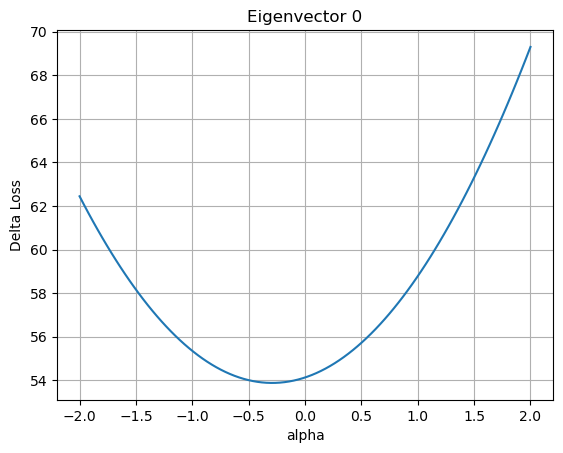

In [10]:
np.set_printoptions(suppress=True)
i = 0
print(f"Analyzing eigenvector {i} with eigenvalue {eigenvalues[i].item()}")
print("Eigenvector")

eigenvec = eigenvectors[:,i]
print(eigenvec.reshape(7,14))
delta_losses = []
for alpha in alphas:
    delta_phi = alpha * gradient / np.linalg.norm(gradient)
    delta_loss = calc_delta_loss_torch(delta_phi, gradient, hessian)
    delta_losses.append(delta_loss + sur_loss)
plt.plot(alphas, delta_losses)
plt.xlabel('alpha')
plt.ylabel('Delta Loss')
plt.title(f'Eigenvector {i}')
plt.grid(True)